<a href="https://colab.research.google.com/github/2303A51795/REINFORCEMENT-LEARNING-BATCH12-2303A51795/blob/main/Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**GridWorld + TD(0) + SARSA, GridWorld Environment**

Greedy w.r.t. V (TD-0)
     ↑      ↑      ↑      ↑ T(1.0)
     ↑      ■      ↑      ↑      ↑
     ↑      ↑      ↑      ■      ↑
     ↑      ↑      ↑      ↑      ↑
T(-1.0)      ↑      ↑      ↑      ↑


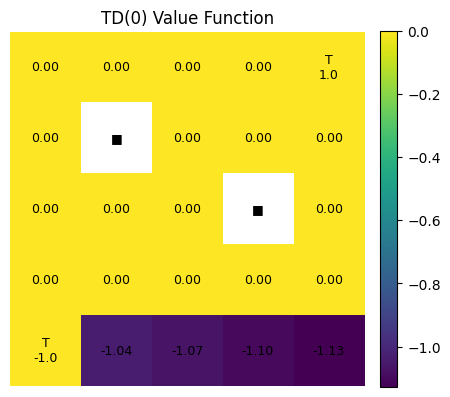

SARSA Learned Policy
     ←      →      →      → T(1.0)
     →      ■      →      →      ↑
     ↓      ↓      ↑      ■      ↑
     →      ↑      →      →      ↑
T(-1.0)      →      →      →      ↑


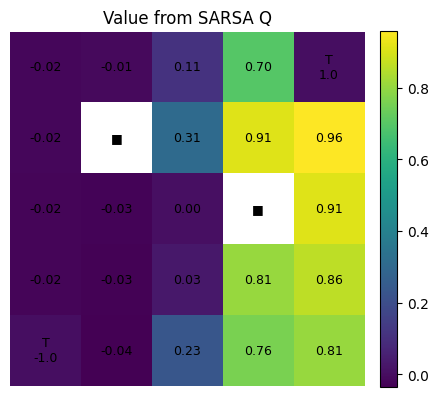

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

# -------------------------
# GridWorld Environment
# -------------------------
class GridWorld:
    ACTIONS = [0, 1, 2, 3]   # 0:UP, 1:RIGHT, 2:DOWN, 3:LEFT
    DIRS = {0:(-1,0), 1:(0,1), 2:(1,0), 3:(0,-1)}
    ARROWS = {0:'↑', 1:'→', 2:'↓', 3:'←'}

    def __init__(self, H=5, W=5, walls=None, terminals=None, step_cost=-0.04,
                 start=None, stochastic_slip=0.0, seed=0):
        self.H, self.W = H, W
        self.walls = set(walls or [])
        self.terminals = dict(terminals or {})
        self.step_cost = step_cost
        self.start = start
        self.stochastic_slip = float(stochastic_slip)
        self.rng = random.Random(seed)

        self.states = [(r,c) for r in range(H) for c in range(W)
                       if (r,c) not in self.walls]
        self.reset()

    def in_bounds(self, r, c):
        return 0 <= r < self.H and 0 <= c < self.W

    def is_terminal(self, s):
        return s in self.terminals

    def sample_initial_state(self):
        if self.start is not None:
            return self.start
        choices = [s for s in self.states if s not in self.terminals]
        return self.rng.choice(choices)

    def reset(self):
        self.s = self.sample_initial_state()
        return self.s

    def step(self, a):
        r, c = self.s
        if self.is_terminal(self.s):
            return self.s, 0.0, True

        eff_a = a
        if self.stochastic_slip > 0.0 and self.rng.random() < self.stochastic_slip:
            eff_a = (a + self.rng.choice([1,3])) % 4

        dr, dc = self.DIRS[eff_a]
        nr, nc = r + dr, c + dc
        if (not self.in_bounds(nr, nc)) or ((nr, nc) in self.walls):
            nr, nc = r, c

        ns = (nr, nc)
        reward = self.step_cost
        if ns in self.terminals:
            reward += self.terminals[ns]
        self.s = ns
        done = self.is_terminal(ns)
        return ns, reward, done

    def all_states(self):
        return list(self.states)

    def legal_actions(self, s=None):
        return list(self.ACTIONS)

# -------------------------
# Helper functions
# -------------------------
def epsilon_greedy(Q, s, actions, epsilon):
    if random.random() < epsilon:
        return random.choice(actions)
    qs = np.array([Q[(s,a)] for a in actions])
    max_q = qs.max()
    best = [a for a in actions if Q[(s,a)] == max_q]
    return random.choice(best)

def greedy_policy_from_V(env, V):
    policy = {}
    for s in env.all_states():
        if env.is_terminal(s):
            policy[s] = None
            continue
        best_a, best_val = None, -1e9
        for a in env.legal_actions(s):
            (r,c) = s
            dr, dc = env.DIRS[a]
            nr, nc = r+dr, c+dc
            if (not env.in_bounds(nr,nc)) or ((nr,nc) in env.walls):
                ns = (r,c)
            else:
                ns = (nr,nc)
            val = V[ns]
            if val > best_val:
                best_val = val
                best_a = a
        policy[s] = best_a
    return policy

def values_to_array(env, V):
    A = np.zeros((env.H, env.W))
    A[:] = np.nan
    for s in env.all_states():
        r,c = s
        A[r,c] = V[s]
    return A

def plot_values(env, V, title="State-Value (V)"):
    A = values_to_array(env, V)
    plt.figure(figsize=(5,5))
    im = plt.imshow(A, interpolation='nearest')
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    for r in range(env.H):
        for c in range(env.W):
            if (r,c) in env.walls:
                txt = '■'
            elif (r,c) in env.terminals:
                txt = f"T\n{env.terminals[(r,c)]:.1f}"
            else:
                txt = f"{A[r,c]:.2f}"
            plt.text(c, r, txt, ha='center', va='center', fontsize=9)
    plt.axis('off')
    plt.show()

def print_policy(env, policy, title="Policy"):
    print(title)
    for r in range(env.H):
        row = []
        for c in range(env.W):
            if (r,c) in env.walls:
                row.append("■")
            elif (r,c) in env.terminals:
                row.append(f"T({env.terminals[(r,c)]:.1f})")
            elif (r,c) in policy and policy[(r,c)] is not None:
                row.append(GridWorld.ARROWS[policy[(r,c)]])
            else:
                row.append("•")
        print(" ".join(f"{x:>6}" for x in row))

# -------------------------
# TD(0) Policy Evaluation
# -------------------------
def td0_policy_evaluation(env, policy, gamma=0.99, alpha=0.1, episodes=500, max_steps=500):
    V = defaultdict(float)
    for _ in range(episodes):
        s = env.reset()
        for _ in range(max_steps):
            if env.is_terminal(s): break
            a = policy(s)
            ns, r, done = env.step(a)
            V[s] += alpha * (r + gamma * (0.0 if done else V[ns]) - V[s])
            s = ns
            if done: break
    return V

# -------------------------
# SARSA Control
# -------------------------
def sarsa_control(env, gamma=0.99, alpha=0.1, epsilon=0.1, episodes=2000, max_steps=500, epsilon_decay=None, min_epsilon=0.01):
    Q = defaultdict(float)
    for ep in range(episodes):
        s = env.reset()
        a = epsilon_greedy(Q, s, env.legal_actions(s), epsilon)
        for _ in range(max_steps):
            ns, r, done = env.step(a)
            na = None
            if not done:
                na = epsilon_greedy(Q, ns, env.legal_actions(ns), epsilon)
                target = r + gamma * Q[(ns,na)]
            else:
                target = r
            Q[(s,a)] += alpha * (target - Q[(s,a)])
            s, a = ns, na
            if done: break
        if epsilon_decay:
            epsilon = max(min_epsilon, epsilon * epsilon_decay)
    policy = {}
    for s in env.all_states():
        if env.is_terminal(s):
            policy[s] = None
            continue
        qs = [Q[(s,a)] for a in env.legal_actions(s)]
        best = np.argmax(qs)
        policy[s] = env.legal_actions(s)[best]
    return Q, policy

# -------------------------
# Example Run
# -------------------------
H, W = 5, 5
walls = {(1,1), (2,3)}
terminals = {(0,4): +1.0, (4,0): -1.0}
env = GridWorld(H=H, W=W, walls=walls, terminals=terminals, step_cost=-0.04, start=(4,4),
                stochastic_slip=0.0, seed=42)

# Fixed policy for TD(0) evaluation
def fixed_policy(state):
    if env.is_terminal(state): return 0
    r,c = state
    pref = [3,0,1,2]  # LEFT > UP > RIGHT > DOWN
    for a in pref:
        dr, dc = env.DIRS[a]
        nr, nc = r+dr, c+dc
        if env.in_bounds(nr,nc) and (nr,nc) not in env.walls:
            return a
    return 0

# --- TD(0) ---
V_td0 = td0_policy_evaluation(env, fixed_policy, gamma=0.99, alpha=0.15, episodes=800)
print_policy(env, greedy_policy_from_V(env, V_td0), title="Greedy w.r.t. V (TD-0)")
plot_values(env, V_td0, title="TD(0) Value Function")

# --- SARSA ---
Q_sarsa, pi_sarsa = sarsa_control(
    env, gamma=0.99, alpha=0.15, epsilon=0.2,
    episodes=4000, max_steps=200, epsilon_decay=0.9995, min_epsilon=0.02
)
print_policy(env, pi_sarsa, title="SARSA Learned Policy")
V_from_Q = defaultdict(float)
for s in env.all_states():
    if env.is_terminal(s):
        V_from_Q[s] = 0.0
    else:
        V_from_Q[s] = max(Q_sarsa[(s,a)] for a in env.legal_actions(s))
plot_values(env, V_from_Q, title="Value from SARSA Q")